# Kernel Density Estimation

a density estimator is an algorithm which takes a D-dimensional dataset and produces an estimate of the D-dimensional probability distribution which that data is drawn from. 

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

For one dimensional data, a histogram is an example of an estimator. It divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

In [8]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

By specifying the `density` parameter, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density

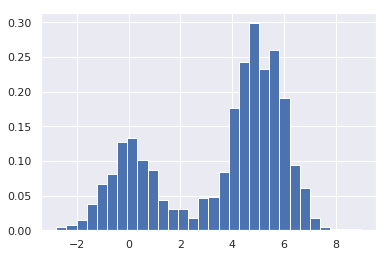

In [9]:
hist = plt.hist(x, bins=30, density=True)

The total area under the histogram should be equal to 1

In [10]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

#### The issue with Histograms

The choice of bin size and location can lead to different representations. 

In [11]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

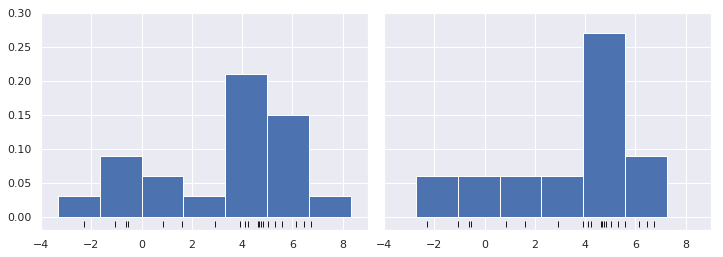

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram has a bimodal distribution. 

On the right, the unimodal distribution with a long tail. 

The distribution is different, despite being built from the same set of data! 

**Stepping back** 

We can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset

(-0.2, 8)

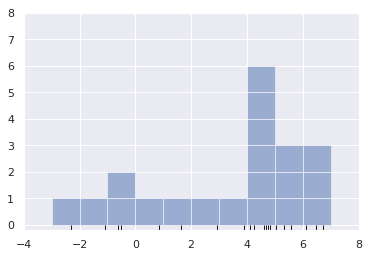

In [13]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points. 

This mis-alignment between points and their blocks is a potential cause of the poor histogram results seen here. 

But what if, instead of stacking the blocks aligned with the bins, we were to stack the blocks aligned with the points they represent?

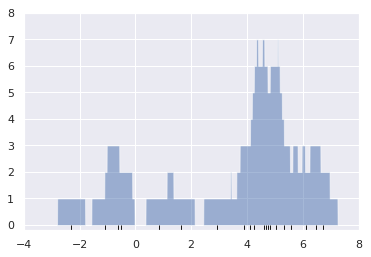

In [14]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram. 

We can use the Gaussian function to smooth out the blocks. 

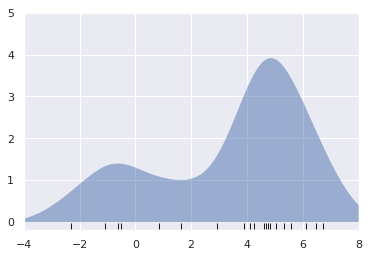

In [15]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel.

### Types of Kernels 

The Sklearn implementation fo KDE gives us 6 types of kernels to choose from: https://scikit-learn.org/stable/modules/density.html

`kernel = 'gaussian'`<br/>
`kernel = 'tophat'`<br/>
`kernel = 'epanechnikov'` <br/>
`kernel = 'exponential'`<br/>
`kernel = 'linear'`<br/>
`kernel = 'cosine'`

Computation time and accuracy can be traded off using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters

(-0.02, 0.22)

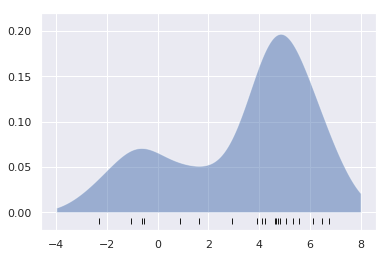

In [16]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

### Selecting Bandwidth via Cross-Validation

Bandwidth controls the bias-variance trade-off in density estimation. <br/>
- Narrow Bandwidth leads to high variance (overfitting) - presence or absence of a single point makes a large difference
- Wide Bandwidth leads to high variance (underfitting) - structure in the data is washed out by the wide kernel

We can use `GridSearchCV` to optimize the bandwidth. 

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [18]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

### Skipped: KDE for geographic distributions

The most common use of KDE is in graphically representing distributions of points.

We will be skipping this section because the Basemap toolkit (For geographic data) is a huge pain to install. 

### Example: Not so Naive Bayes

With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. It's still Bayesian classification, but it's no longer naive.

The general approach for generative classification is this:

1) Split the training data by label.

2) For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation x and label y to compute a likelihood P(x | y).

3) From the number of examples of each class in the training set, compute the class prior, P(y).

4) For an unknown point x, the posterior probability for each class is P(y | x)∝P(x | y)P(y). The class which maximizes this posterior is the label assigned to the point.

This is the code that implements that sklearn algorithm behind the scenes.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### Using our custom estimator to classify handwritten digits

In [21]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
import numpy as np

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.cv_results_]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


AttributeError: 'str' object has no attribute 'mean_validation_score'

Plot Cross-validation score as a function of bandwidth

In [ ]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

Our not-so-naive Bayesian classifier has an accuracy of 96%! This is better than 80% for standard naive classification

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

#### Advantage of Generative Classfier

One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a full model of the distribution of points we are comparing it to